<a href="https://colab.research.google.com/github/asifmanowar9/BanglaTaka/blob/main/Code/BanglaTaka_Asif(new)ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Classify Bangladeshi banknote images using a pre-trained ResNet50 model, utilizing the dataset located in the Google Drive folder 'https://drive.google.com/drive/folders/13P5Soos4thSeu9Su62lHVENzrSF3kxCA'.

## Mount Google Drive

### Subtask:
Mount your Google Drive to access the dataset directly from the provided link: 'https://drive.google.com/drive/folders/13P5Soos4thSeu9Su62lHVENzrSF3kxCA'.


**Reasoning**:
To mount Google Drive, I need to import the drive module from google.colab and then call the drive.mount() function.



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load and Preprocess Dataset

### Subtask:
Load the images from the mounted Google Drive, preprocess them (e.g., resize to a standard input size for ResNet50 like 224x224, normalize pixel values), and create corresponding labels based on the folder structure. Make sure to handle image loading and basic augmentation for training.


In [3]:
import os

drive_path = '/content/drive/MyDrive/aa/dataset' # Replace 'Your_Shortcut_Name' with the actual name of your shortcut

if os.path.exists(drive_path):
    print(f"Listing contents of '{drive_path}':")
    for item in os.listdir(drive_path):
        print(item)
else:
    print(f"Error: The path '{drive_path}' does not exist. Please check your shortcut name and path.")

Listing contents of '/content/drive/MyDrive/aa/dataset':
100
200
500
1000
50
2
5
10
20


## Load and Prepare Data

defines image dimensions and batch size, sets the corrected dataset root path, loads the dataset, prints class names, defines and applies a normalization function, and verifies the preprocessing.

In [4]:
import tensorflow as tf

# 1. Define image dimensions and batch size
img_height = 128
img_width = 128
batch_size = 32

# 2. Set the dataset_root variable to the confirmed path
dataset_root = '/content/drive/MyDrive/aa/dataset'

print(f"Attempting to load dataset from: {dataset_root}")

try:
    # 3. Load the image dataset using image_dataset_from_directory
    raw_train_ds = tf.keras.utils.image_dataset_from_directory(
        dataset_root,
        labels='inferred',
        label_mode='int',
        image_size=(img_height, img_width),
        interpolation='nearest',
        batch_size=batch_size,
        shuffle=True,
        seed=42 # for reproducibility
    )

    # 4. Print class names and approximate number of images
    class_names = raw_train_ds.class_names
    print(f"\nClasses found: {class_names}")
    print(f"Number of classes: {len(class_names)}")

    # Corrected: Handle cardinality carefully
    total_batches_cardinality = tf.data.experimental.cardinality(raw_train_ds)
    if total_batches_cardinality == tf.data.AUTOTUNE:
        print("Total number of batches could not be determined (tf.data.AUTOTUNE). Dataset size might be very large.")
    else:
        # Ensure we call .numpy() only if it's a TensorFlow Tensor
        total_batches = total_batches_cardinality.numpy() if hasattr(total_batches_cardinality, 'numpy') else total_batches_cardinality
        total_images = total_batches * batch_size
        print(f"Approximate total number of images in the dataset: {total_images}")

    # 5. Preprocessing function for normalization (corrected)
    def preprocess(image, label):
        image = tf.cast(image, tf.float32) / 255.0 # Cast image to float32 first, then divide
        return image, label

    # 6. Apply preprocessing to the dataset
    processed_train_ds = raw_train_ds.map(preprocess)
    print("\nImage normalization preprocessing applied to the dataset.")

    # 7. Verify preprocessing by taking one batch
    for image_batch, labels_batch in processed_train_ds.take(1):
        print(f"\nShape of one image batch after preprocessing: {image_batch.shape}")
        print(f"Min pixel value in one image batch: {tf.reduce_min(image_batch)}")
        print(f"Max pixel value in one image batch: {tf.reduce_max(image_batch)}")
        print(f"Shape of one label batch: {labels_batch.shape}")
        break

except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please ensure the 'dataset_root' is correct and points to a directory containing image subfolders (classes).")
    print("Example: '/content/drive/MyDrive/DSA_Project_Folder'")

Attempting to load dataset from: /content/drive/MyDrive/aa/dataset
Found 10634 files belonging to 9 classes.

Classes found: ['10', '100', '1000', '2', '20', '200', '5', '50', '500']
Number of classes: 9
Approximate total number of images in the dataset: 10656

Image normalization preprocessing applied to the dataset.

Shape of one image batch after preprocessing: (32, 128, 128, 3)
Min pixel value in one image batch: 0.0
Max pixel value in one image batch: 1.0
Shape of one label batch: (32,)


## Split Dataset

Split the prepared dataset into training, validation, and test sets to properly evaluate the model's generalization capabilities.

This ensures that the model is trained on one part of the data, fine-tuned on another (validation), and finally evaluated on unseen data (test set) to provide an unbiased assessment of its performance.

**Instructions:**
1.  **Determine Total Images**: We'll use the `total_images` variable calculated in the previous step as an approximation for the dataset size.
2.  **Define Split Ratios**: We will use a standard split of 70% for training, 15% for validation, and 15% for testing.
3.  **Calculate Batches**: The dataset is already batched, so we will determine the number of batches for each split based on the ratios and the overall number of batches.
4.  **Create Subsets**: TensorFlow's `tf.data.Dataset` API provides efficient methods (`take`, `skip`) for creating these subsets.
5.  **Optimize Performance**: Apply `.cache()` and `.prefetch()` to each dataset split to improve training efficiency. `.cache()` keeps images in memory after the first epoch, and `.prefetch()` overlaps data preprocessing and model execution.

In [5]:
import math

# Assuming `processed_train_ds` and `batch_size` are available from previous steps
# `total_images` was also calculated, but it's more robust to calculate based on `processed_train_ds` cardinality if possible.
# Let's re-evaluate total batches to be sure, assuming `raw_train_ds` is the source.

# Get the total number of batches from the processed dataset
total_batches_cardinality = tf.data.experimental.cardinality(processed_train_ds)
if total_batches_cardinality == tf.data.AUTOTUNE:
    # Fallback to the approximate total_images if cardinality is not concrete
    if 'total_images' in locals():
        total_images_approx = total_images # Use previously calculated approximate total_images
        total_batches_approx = math.ceil(total_images_approx / batch_size)
    else:
        print("Warning: Cannot determine total number of batches or images for splitting. Please ensure 'processed_train_ds' is properly formed.")
        # For demonstration, assign a default value or raise an error
        total_batches_approx = 100 # Placeholder for a real scenario, this would cause issues
else:
    total_batches_approx = total_batches_cardinality.numpy() # Convert Tensor to Python int

print(f"Total batches in processed dataset: {total_batches_approx}")

# Define split ratios
train_split_ratio = 0.7
val_split_ratio = 0.15
test_split_ratio = 0.15

# Calculate number of batches for each split
train_batches = int(total_batches_approx * train_split_ratio)
val_batches = int(total_batches_approx * val_split_ratio)

# The remaining batches go to the test set
test_batches = total_batches_approx - train_batches - val_batches

print(f"\nSplitting dataset:")
print(f"  Training batches: {train_batches}")
print(f"  Validation batches: {val_batches}")
print(f"  Test batches: {test_batches}")

# Create the training, validation, and test datasets
train_ds = processed_train_ds.take(train_batches)
val_ds = processed_train_ds.skip(train_batches).take(val_batches)
test_ds = processed_train_ds.skip(train_batches).skip(val_batches)

# Verify the number of batches in each split (optional, for debugging)
print(f"\nBatches after splitting:")
print(f"  Train dataset batches (actual): {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"  Validation dataset batches (actual): {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"  Test dataset batches (actual): {tf.data.experimental.cardinality(test_ds).numpy()}")

# Optimize performance with .cache() and .prefetch()
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("\nDatasets (train_ds, val_ds, test_ds) created and optimized with .cache() and .prefetch().")

Total batches in processed dataset: 333

Splitting dataset:
  Training batches: 233
  Validation batches: 49
  Test batches: 51

Batches after splitting:
  Train dataset batches (actual): 233
  Validation dataset batches (actual): 49
  Test dataset batches (actual): 51

Datasets (train_ds, val_ds, test_ds) created and optimized with .cache() and .prefetch().


## Build and Compile CNN Model

Now we will construct the Convolutional Neural Network (CNN) model. We'll leverage transfer learning by using a pre-trained base model (ResNet50) and then add custom classification layers on top. Finally, we'll compile the model with suitable settings for training.

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import ResNet50 # Changed from MobileNetV2
from tensorflow.keras import Sequential

# Assuming img_height, img_width, and class_names are defined from previous steps
# img_height = 128
# img_width = 128
# class_names = ['10', '100', '1000', '2', '20', '200', '5', '50', '500'] # Example

print(f"Image dimensions: ({img_height}, {img_width})")
print(f"Number of classes: {len(class_names)}")

# 1. Load a pre-trained base model (ResNet50) without its top classification layer
base_model = ResNet50(input_shape=(img_height, img_width, 3),
                           include_top=False,
                           weights='imagenet')

# 2. Freeze the base model's layers
base_model.trainable = False

# 3. Create a new Sequential model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(), # Converts feature maps to a single vector
    Dense(128, activation='relu'), # A hidden dense layer
    Dense(len(class_names), activation='softmax') # Output layer for multi-class classification
])

# 4. Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# 5. Print a summary of the model
print("\nModel Architecture Summary:")
model.summary()

print("\nCNN model built and compiled successfully using ResNet50.")

Image dimensions: (128, 128)
Number of classes: 9
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

Model Architecture Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,851,145 (90.98 MB)

 Trainable params: 263,433 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


CNN model built and compiled successfully using ResNet50.


In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

print("Model compiled successfully!")

Model compiled successfully!


##Train the model

In [8]:
EPOCHS = 10 # You can adjust this number

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

print("Model training complete. History stored.")

Epoch 1/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 2161s 9s/step - accuracy: 0.2672 - loss: 2.0111 - val_accuracy: 0.5938 - val_loss: 1.5274
Epoch 2/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 546s 2s/step - accuracy: 0.5730 - loss: 1.4131 - val_accuracy: 0.7500 - val_loss: 1.0930
Epoch 3/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 589s 3s/step - accuracy: 0.7503 - loss: 1.0183 - val_accuracy: 0.7966 - val_loss: 0.8379
Epoch 4/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 541s 2s/step - accuracy: 0.8071 - loss: 0.7833 - val_accuracy: 0.8106 - val_loss: 0.6947
Epoch 5/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 541s 2s/step - accuracy: 0.8327 - loss: 0.6462 - val_accuracy: 0.8214 - val_loss: 0.6158
Epoch 6/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 565s 2s/step - accuracy: 0.8410 - loss: 0.5654 - val_accuracy: 0.8284 - val_loss: 0.5686
Epoch 7/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 557s 2s/step - accuracy: 0.8553 - loss: 0.5142 - val_accuracy: 0.8342 - val_loss: 0.5371
Epoch 8/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 539s 2s/step - accuracy: 0.8618 - loss: 0.4785 - val_acc

##Save the trained model to drive

In [9]:
model.save('/content/drive/MyDrive/resnet50_trained_model_banglaTaka.keras')

In [10]:
model.save('/content/drive/MyDrive/resnet50_trained_model_banglaTaka1.keras')

# Task
Select a single image and its label from the `test_ds` dataset, preprocess it for model prediction, use the trained `model` to predict its class, and then display the image along with its true label, predicted label, and the confidence scores for all classes.

## Select and Preprocess Image for Prediction

### Subtask:
Select a single image and its label from the test dataset (`test_ds`), preprocess it (resize and normalize), and prepare it for model prediction. The image will be expanded to a batch dimension.


**Reasoning**:
To prepare a single image for prediction, I need to extract one image and its corresponding label from the `test_ds` dataset, and then expand its dimensions to match the model's expected input shape (batch dimension).



In [11]:
import tensorflow as tf

# 1. Get the first batch of images and labels from the test_ds dataset
for image_batch, labels_batch in test_ds.take(1):
    # 2. Extract the first image and its corresponding label from this batch
    test_image = image_batch[0]
    true_label_index = labels_batch[0]
    break # Exit after taking the first batch

# 3. Expand the dimensions of the test_image to create a batch of one image
# The model expects a batch input, so we add an extra dimension at the beginning.
input_image_for_prediction = tf.expand_dims(test_image, 0)

print(f"Original image shape: {test_image.shape}")
print(f"True label index: {true_label_index.numpy()}")
print(f"Input image shape for prediction (with batch dim): {input_image_for_prediction.shape}")

print("Single image selected and prepared for prediction.")

Original image shape: (128, 128, 3)
True label index: 0
Input image shape for prediction (with batch dim): (1, 128, 128, 3)
Single image selected and prepared for prediction.


**Reasoning**:
Now that a single image has been prepared for prediction, the next step is to use the trained model to make a prediction on this image. After obtaining the prediction, I will interpret the results to get the predicted class and its confidence.



1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


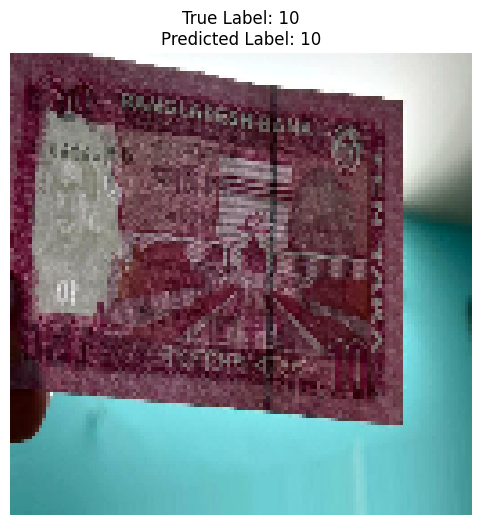


True Label: 10
Predicted Label: 10
Confidence Scores (for all classes):
  10: 0.9729
  100: 0.0159
  1000: 0.0001
  2: 0.0006
  20: 0.0003
  200: 0.0010
  5: 0.0001
  50: 0.0088
  500: 0.0003
Model prediction complete and results displayed.


In [12]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Make a prediction using the model
predictions = model.predict(input_image_for_prediction)

# 2. Get the predicted class index (index with the highest probability)
predicted_label_index = np.argmax(predictions[0])

# 3. Map the true label index and predicted label index to their respective class names
true_label_name = class_names[true_label_index.numpy()]
predicted_label_name = class_names[predicted_label_index]

# 4. Display the results
plt.figure(figsize=(6, 6))
plt.imshow(test_image) # Display the normalized image
plt.title(f"True Label: {true_label_name}\nPredicted Label: {predicted_label_name}")
plt.axis('off')
plt.show()

print(f"\nTrue Label: {true_label_name}")
print(f"Predicted Label: {predicted_label_name}")
print("Confidence Scores (for all classes):")
for i, score in enumerate(predictions[0]):
    print(f"  {class_names[i]}: {score:.4f}")

print("Model prediction complete and results displayed.")

## Final Task

### Subtask:
Summarize the prediction result for the selected image, stating the predicted and actual classes.


## Summary:

### Q&A
For the selected image, the true class was '10', and the model also predicted the class as '10'. The confidence score for class '10' was 0.9729.

### Data Analysis Key Findings
*   A single image with an original shape of (128, 128, 3) was selected from the `test_ds` dataset and preprocessed by adding a batch dimension, resulting in an input shape of (1, 128, 128, 3) for the model.
*   The true label index for this image was `0`, which mapped to class '10'.
*   The trained model predicted the class of the selected image as '10'.
*   The confidence score for the predicted class '10' was high at 0.9729.

### Insights or Next Steps
*   The model successfully classified the selected image with high confidence, indicating good performance for this specific instance.
*   To further assess the model's robustness, it would be beneficial to evaluate its performance on a larger subset of the `test_ds` dataset, including diverse examples and potential edge cases.
